<center><span style="color:blue; font-weight:bold;font-size:40px"> Détection du cancer de sein par des images d'histopathologie mammaire et CNN </span></center>

<left><span style="color:black; font-weight:bold;font-size:15px"> SOGO Armel Emmanuel</span></left>

Le cancer du sein est une maladie caractérisée par la croissance incontrôlée de cellules mammaires anormales qui forment alors des tumeurs. Si rien n’est fait, les tumeurs peuvent se propager dans l’organisme et avoir une issue fatale.\
En 2020, l'OMS a recensé 2,3 millions de cas féminins et 685 000 décès dus au cancer du sein dans le monde. À la fin de 2020, 7,8 millions de femmes en vie s’étaient vues diagnostiquer un cancer du sein au cours des cinq années précédentes, ce qui en fait le type de cancer le plus courant à l’échelle du globe. Présent dans tous les pays, le cancer du sein touche les femmes de tous âges à partir de la puberté, mais son incidence croît à mesure que l’âge avance.\
Le carcinome invasif est la forme la plus courante de cancer du sein. L'identification et la catégorisation précises des sous-types de cancer du sein est une tâche clinique importante, et des méthodes automatisées peuvent être utilisées pour gagner du temps et réduire les erreurs.\
L'objectif de ce travail est d'identifier le cancer du sein lorsqu'il est présent. 

# Importation des bibliothèques néccéssaire

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import cv2 
import glob
import tensorflow as tf
import keras.utils as image
from keras.preprocessing import image
import random
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold


# Importation de la base de données

In [2]:
cancer_img = glob.glob('F:/Data_Breast_Cancer/IDC_regular_ps50_idx5/**/*.png', recursive = True)
len(cancer_img)


277524

Le nombre total d'image est de 277524

# Exploration et analyse des données
## Visualisation des données

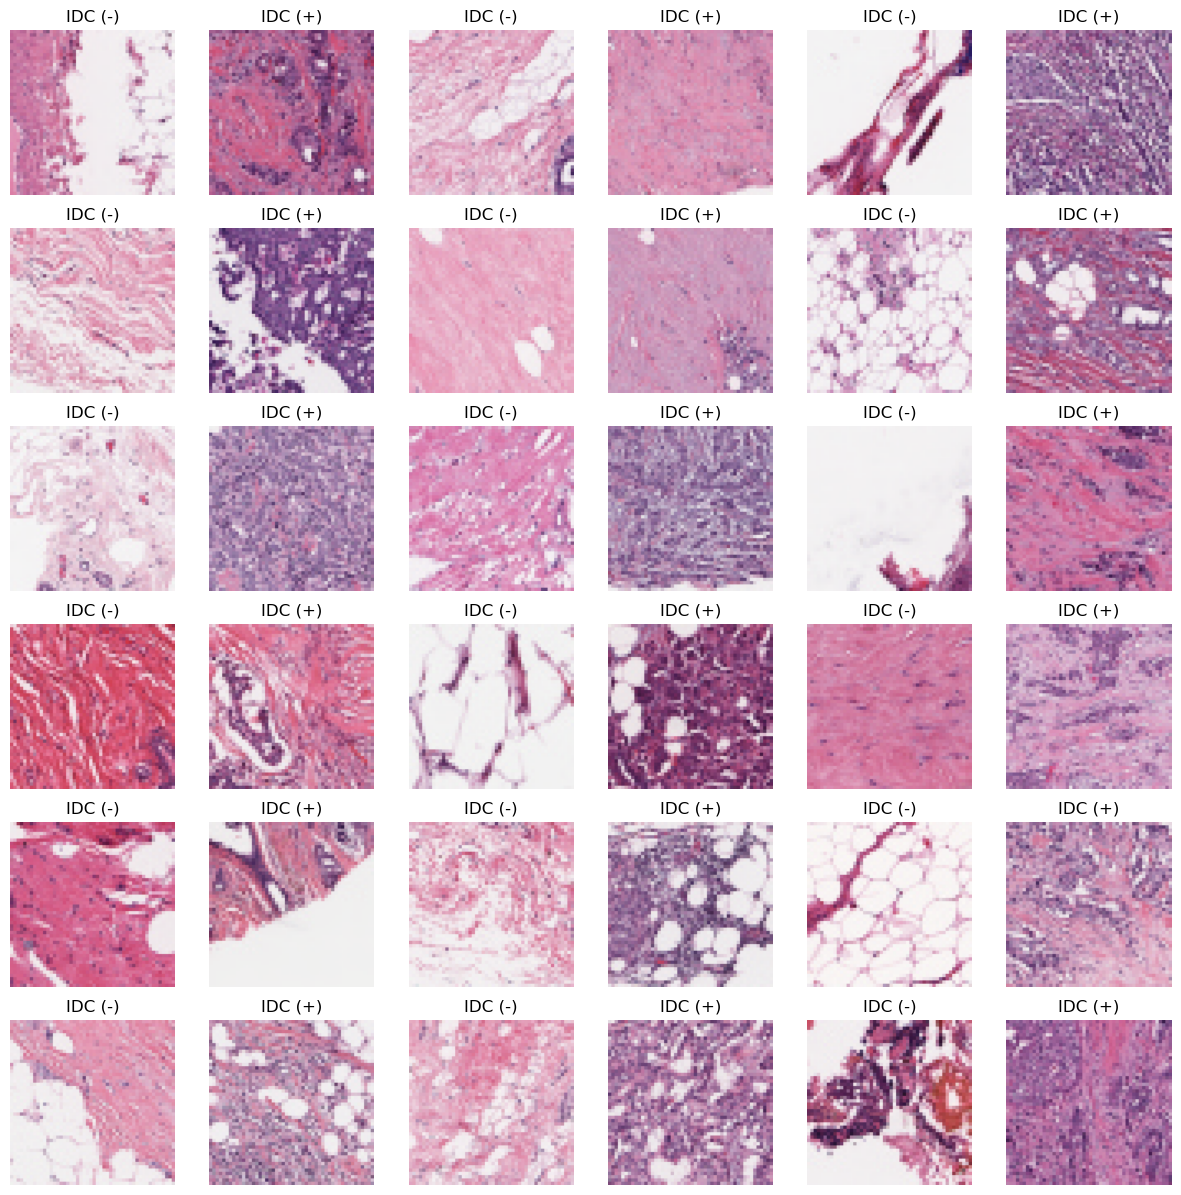

In [3]:
# Groupage des femmes Cancer + et Cancer -

N_IDC = [img for img in cancer_img if img[-5] == '0']
Y_IDC = [img for img in cancer_img if img[-5] == '1']
plt.figure(figsize=(15, 15))

# Sélection aléatoire d'indices pour les images sans cancer et avec cancer
indices_non_cancer = np.random.choice(len(N_IDC), size=18, replace=False)
indices_cancer = np.random.choice(len(Y_IDC), size=18, replace=False)


# Affichage des images sans cancer
for i, idx in enumerate(indices_non_cancer):
    img = image.load_img(N_IDC[idx], target_size=(100, 100))
    img = image.img_to_array(img)
    plt.subplot(6, 6, 2*i + 1)
    plt.axis('off')
    plt.title('IDC (-)')
    plt.imshow(img.astype('uint8'))

# Affichage des images avec cancer
for i, idx in enumerate(indices_cancer):
    img = image.load_img(Y_IDC[idx], target_size=(100, 100))
    img = image.img_to_array(img)
    plt.subplot(6, 6, 2*i + 2)
    plt.axis('off')
    plt.title('IDC (+)')
    plt.imshow(img.astype('uint8'))

plt.show()


## Tabulation des classes

In [15]:
# Nombre de femmes sans cancer (IDC négatif)
nb_img_negatif = len(N_IDC)

# Nombre de femmes avec cancer (IDC positif)
nb_img_positif = len(Y_IDC)

print("Nombre d'image avec cancer (IDC positif) :", nb_img_positif)
print("Nombre d'image sans cancer (IDC négatif) :", nb_img_negatif)


Nombre d'image avec cancer (IDC positif) : 78786
Nombre d'image sans cancer (IDC négatif) : 198738


Dans notre base de données 198738 images ne présentaient pas de cancer contre  78786 positifs

## Traitement et normalisation des images

Etant donnée donné que nous allons utilisé les réseaux neuronaux convolutionnels (CNN) comme algorithme d'apprentissage, nous proposons de sélectionner le même nombre d'image dans les deux classes àfin d'aider à équiliber les classes et à éviter tout biaiss dans le modèle d'apprentissage. Pour ce ce faire nous allons séléctionné 78786 images  n'ayant pas de cancer et nous garderons les 78786 images de cancer + pour faire le traitement

In [5]:
N_IDC_new=N_IDC[:78786] # Nouvelle variable d'image non cancer
print(len(N_IDC_new))
print(len(Y_IDC))

78786
78786


## Traitement et normalisation des images

Ici nous rédimensionnons, normalisons les images et les stockons dans des tableux
* Traitement des images sans cancer (IDC négatif)

In [6]:
# Ici nous rédimensionnons, normalisons les images et les stockons dans des tableux

N_Canc_img_arr = []
Y_can_img_arr = []

# Traitement des images sans cancer (IDC négatif)
for img in N_IDC_new:
   n_img = cv2.imread(img, cv2.IMREAD_COLOR)
   if n_img is not None:
       n_img_size = cv2.resize(n_img, (25, 25), interpolation=cv2.INTER_LINEAR)
       n_img_size = n_img_size.astype('float32') / 255.0    # Normalisation des pixels     
       N_Canc_img_arr.append([n_img_size, 0])


* Traitement des images avec cancer (IDC positif)

In [7]:
# Traitement des images avec cancer (IDC positif)
for img in Y_IDC:
    c_img = cv2.imread(img, cv2.IMREAD_COLOR)
    if c_img is not None:
        c_img_size = cv2.resize(c_img, (25, 25), interpolation=cv2.INTER_LINEAR)
        c_img_size = c_img_size.astype('float32') / 255.0   # Normalisation des pixels
        Y_can_img_arr.append([c_img_size, 1])


        

# Préparation des données d'entrainement et de test

Ici nous allons sélectionné 60000 images de cancer positif et 60000 de cancer négatif que nous allons concaténé pour cré notre jeu de données. 

In [8]:
X = []
y = []

# Concaténer les listes de caractéristiques et d'étiquettes
img_canc = N_Canc_img_arr[:60000] + Y_can_img_arr[:60000] # pas beacoup de mémoire donc nous optons pour une sélection de 20000 images 
# par classe
# Mélanger aléatoirement les éléments de la liste
random.shuffle(img_canc)

# Parcourir la liste concaténée et extraire les caractéristiques et les étiquettes
for feature, label in img_canc:
    X.append(feature)
    y.append(label)
    
# Convertir les listes en tableaux numpy
X = np.array(X)
y = np.array(y)


## Division des données en ensemble de test et d'entrainement
 70% des données seront reservées pour l'entrainement et 30% pour le test


In [9]:


# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3 , random_state=42)

print("Taille de données d'entrainement X:", X_train.shape)
print("Taille de données d'entrainement Y :", y_train.shape)
print("Taille de données de test X :", X_test.shape)
print("Taille de données de test Y :", y_test.shape)

Taille de données d'entrainement X: (84000, 25, 25, 3)
Taille de données d'entrainement Y : (84000,)
Taille de données de test X : (36000, 25, 25, 3)
Taille de données de test Y : (36000,)


## Définition du modèle


Nous allons crér un modèle séquentiel convolutif simple  nommé "modele_CNN" composé de:

* Trois couches de convolution Conv2D avec respectivement 32, 64 et 128 filtres, de  (3, 3) et une activation ReLU.
* Deux couches de max pooling avec un pool size de (2, 2) pour réduire la dimensionnalité.
* Deux couches dropout avec un taux de régularisation de 0.3 pour éviter le surajustement.
* Une couche flatten pour convertir les données en un vecteur 1D afin de les alimenter dans les couches fully-connected.
* Une couche dense avec 64 neurones et une activation ReLU pour extraire des caractéristiques plus abstraites.
* Enfin, une couche dense de sortie avec une activation sigmoid pour effectuer la classification binaire.

Notre modèl est ensuite compilé  en utilisant l'optimiseur Adam avec un taux d'apprentissage de 0,0001, une perte de cross-entropy binaire et une métrique d'exactitude (accuracy) pour évaluer les performances du modèle pendant l'entraînement.


In [10]:


def modele_CNN():
    model = Sequential()
    
    # Première couche convolutive avec 32 filtres de taille 3x3 et activation ReLU
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(25, 25, 3)))
    
    # Deuxième couche convolutive avec 64 filtres de taille 3x3 et activation ReLU
    model.add(Conv2D(64, (3, 3), activation='relu'))
    
    # Couche de max pooling pour réduire la dimensionnalité
    model.add(MaxPooling2D((2, 2)))
    
    # Couche de dropout pour la régularisation
    model.add(Dropout(0.3))
    
    # Troisième couche convolutive avec 128 filtres de taille 3x3 et activation ReLU
    model.add(Conv2D(128, (3, 3), activation='relu'))
    
    # Nouvelle couche de max pooling
    model.add(MaxPooling2D((2, 2)))
    
    # Nouvelle couche de dropout
    model.add(Dropout(0.3))
    
    # Aplatissement des données pour les couches entièrement connectées
    model.add(Flatten())
    
    # Première couche dense avec 64 neurones et activation ReLU
    model.add(Dense(64, activation='relu'))
    
    # Couche de sortie avec activation sigmoïde pour la classification binaire
    model.add(Dense(1, activation='sigmoid'))
    
    # Compilation du modèle avec l'optimiseur Adam et la fonction de perte binaire_crossentropy
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

# Création du modèle CNN
CNN_model = modele_CNN()
CNN_model.summary()




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 23, 23, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 21, 21, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2  (None, 10, 10, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 10, 10, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 128)         73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 4, 4, 128)         0         
 g2D)                                                 

# Entrainement du modèle

Notre modèle sera entrainer en utilisant la validation croisé "K-fold" pour évaluer la performance du modèle afin d'avoir une evaluation robuste de notre modèle. Les données sont alors partitionné en 5 (k=5) sous ensembles de tailles égales. Le modèle est entrainé 5 fois avec chacune des sous  données d'entrainement et de test. La performence du modèle est moyennée sur les 5 itérations pour obténir l'estimation global de la performance du modèle. 

Epoch 1/50


2100/2100 [==============================] - 58s 26ms/step - loss: 0.5190 - accuracy: 0.7447 - val_loss: 0.4751 - val_accuracy: 0.7760
Epoch 2/50
2100/2100 [==============================] - 70s 33ms/step - loss: 0.4438 - accuracy: 0.7961 - val_loss: 0.4273 - val_accuracy: 0.8067
Epoch 3/50
2100/2100 [==============================] - 58s 28ms/step - loss: 0.3913 - accuracy: 0.8258 - val_loss: 0.3666 - val_accuracy: 0.8430
Epoch 4/50
2100/2100 [==============================] - 55s 26ms/step - loss: 0.3701 - accuracy: 0.8374 - val_loss: 0.3571 - val_accuracy: 0.8474
Epoch 5/50
2100/2100 [==============================] - 55s 26ms/step - loss: 0.3565 - accuracy: 0.8431 - val_loss: 0.3409 - val_accuracy: 0.8546
Epoch 6/50
2100/2100 [==============================] - 54s 26ms/step - loss: 0.3459 - accuracy: 0.8491 - val_loss: 0.3502 - val_accuracy: 0.8446
Epoch 7/50
2100/2100 [==============================] - 56s 27ms/step - loss: 0.3397 - accuracy: 0.8521 - val_loss: 0.3301

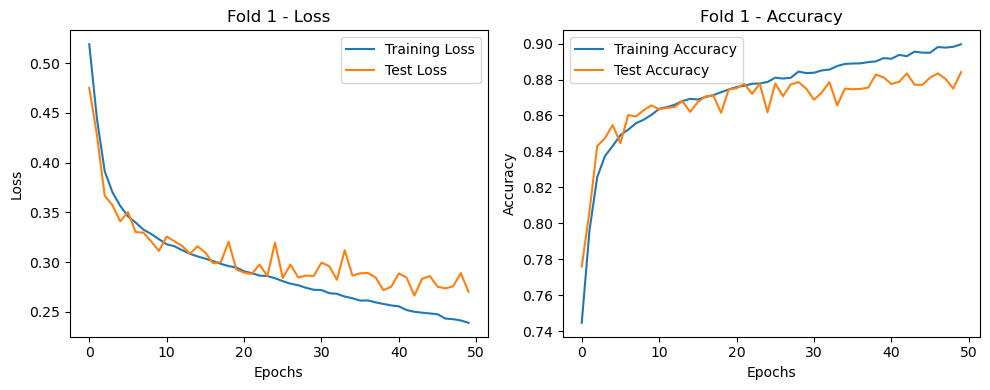

Epoch 1/50
2100/2100 [==============================] - 49s 23ms/step - loss: 0.5185 - accuracy: 0.7440 - val_loss: 0.4618 - val_accuracy: 0.7881
Epoch 2/50
2100/2100 [==============================] - 48s 23ms/step - loss: 0.4461 - accuracy: 0.7959 - val_loss: 0.4206 - val_accuracy: 0.8142
Epoch 3/50
2100/2100 [==============================] - 48s 23ms/step - loss: 0.4039 - accuracy: 0.8181 - val_loss: 0.3957 - val_accuracy: 0.8260
Epoch 4/50
2100/2100 [==============================] - 47s 23ms/step - loss: 0.3772 - accuracy: 0.8336 - val_loss: 0.4521 - val_accuracy: 0.7840
Epoch 5/50
2100/2100 [==============================] - 47s 23ms/step - loss: 0.3600 - accuracy: 0.8417 - val_loss: 0.3585 - val_accuracy: 0.8450
Epoch 6/50
2100/2100 [==============================] - 48s 23ms/step - loss: 0.3518 - accuracy: 0.8464 - val_loss: 0.3473 - val_accuracy: 0.8574
Epoch 7/50
2100/2100 [==============================] - 47s 22ms/step - loss: 0.3456 - accuracy: 0.8494 - val_loss: 0.3371 -

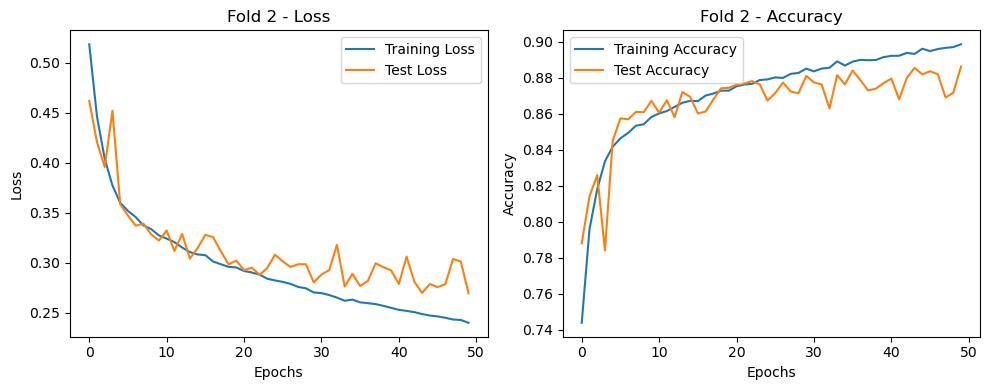

Epoch 1/50
2100/2100 [==============================] - 50s 23ms/step - loss: 0.5171 - accuracy: 0.7461 - val_loss: 0.4478 - val_accuracy: 0.7962
Epoch 2/50
2100/2100 [==============================] - 48s 23ms/step - loss: 0.4189 - accuracy: 0.8095 - val_loss: 0.3888 - val_accuracy: 0.8242
Epoch 3/50
2100/2100 [==============================] - 51s 24ms/step - loss: 0.3808 - accuracy: 0.8291 - val_loss: 0.3519 - val_accuracy: 0.8490
Epoch 4/50
2100/2100 [==============================] - 50s 24ms/step - loss: 0.3647 - accuracy: 0.8394 - val_loss: 0.3425 - val_accuracy: 0.8523
Epoch 5/50
2100/2100 [==============================] - 48s 23ms/step - loss: 0.3544 - accuracy: 0.8442 - val_loss: 0.3410 - val_accuracy: 0.8595
Epoch 6/50
2100/2100 [==============================] - 46s 22ms/step - loss: 0.3459 - accuracy: 0.8501 - val_loss: 0.3640 - val_accuracy: 0.8417
Epoch 7/50
2100/2100 [==============================] - 46s 22ms/step - loss: 0.3400 - accuracy: 0.8522 - val_loss: 0.3259 -

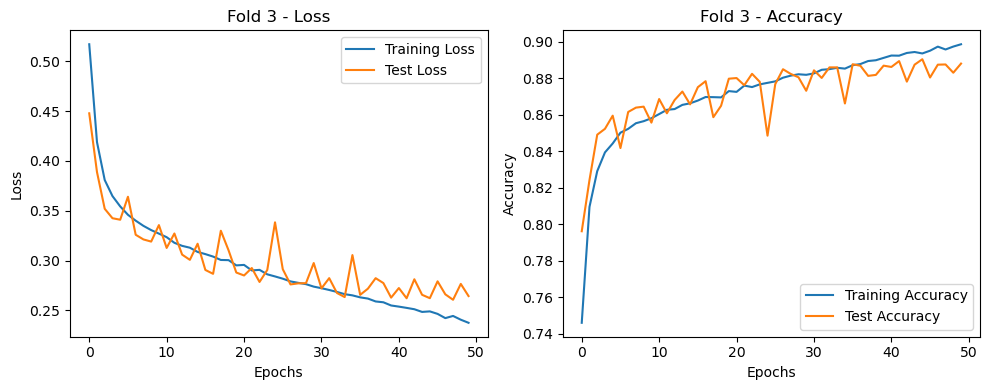

Epoch 1/50
2100/2100 [==============================] - 49s 23ms/step - loss: 0.5316 - accuracy: 0.7286 - val_loss: 0.4910 - val_accuracy: 0.7701
Epoch 2/50
2100/2100 [==============================] - 48s 23ms/step - loss: 0.4546 - accuracy: 0.7900 - val_loss: 0.4601 - val_accuracy: 0.7873
Epoch 3/50
2100/2100 [==============================] - 49s 23ms/step - loss: 0.4122 - accuracy: 0.8143 - val_loss: 0.4047 - val_accuracy: 0.8235
Epoch 4/50
2100/2100 [==============================] - 50s 24ms/step - loss: 0.3833 - accuracy: 0.8303 - val_loss: 0.3891 - val_accuracy: 0.8251
Epoch 5/50
2100/2100 [==============================] - 49s 23ms/step - loss: 0.3673 - accuracy: 0.8377 - val_loss: 0.3566 - val_accuracy: 0.8489
Epoch 6/50
2100/2100 [==============================] - 48s 23ms/step - loss: 0.3542 - accuracy: 0.8446 - val_loss: 0.3483 - val_accuracy: 0.8518
Epoch 7/50
2100/2100 [==============================] - 47s 22ms/step - loss: 0.3456 - accuracy: 0.8507 - val_loss: 0.3647 -

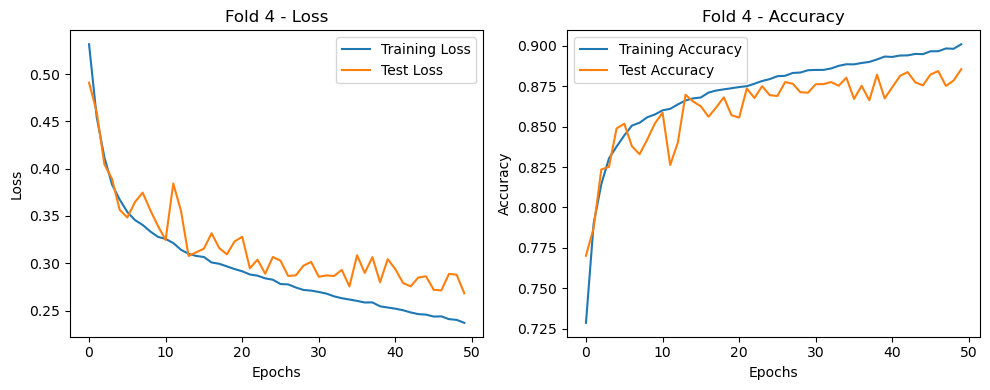

Epoch 1/50
2100/2100 [==============================] - 68s 30ms/step - loss: 0.5316 - accuracy: 0.7320 - val_loss: 0.4809 - val_accuracy: 0.7861
Epoch 2/50
2100/2100 [==============================] - 52s 25ms/step - loss: 0.4467 - accuracy: 0.7946 - val_loss: 0.3914 - val_accuracy: 0.8292
Epoch 3/50
2100/2100 [==============================] - 48s 23ms/step - loss: 0.4021 - accuracy: 0.8181 - val_loss: 0.3791 - val_accuracy: 0.8314
Epoch 4/50
2100/2100 [==============================] - 46s 22ms/step - loss: 0.3761 - accuracy: 0.8334 - val_loss: 0.3630 - val_accuracy: 0.8527
Epoch 5/50
2100/2100 [==============================] - 49s 24ms/step - loss: 0.3632 - accuracy: 0.8390 - val_loss: 0.3552 - val_accuracy: 0.8515
Epoch 6/50
2100/2100 [==============================] - 56s 27ms/step - loss: 0.3521 - accuracy: 0.8464 - val_loss: 0.3438 - val_accuracy: 0.8580
Epoch 7/50
2100/2100 [==============================] - 49s 23ms/step - loss: 0.3441 - accuracy: 0.8496 - val_loss: 0.3303 -

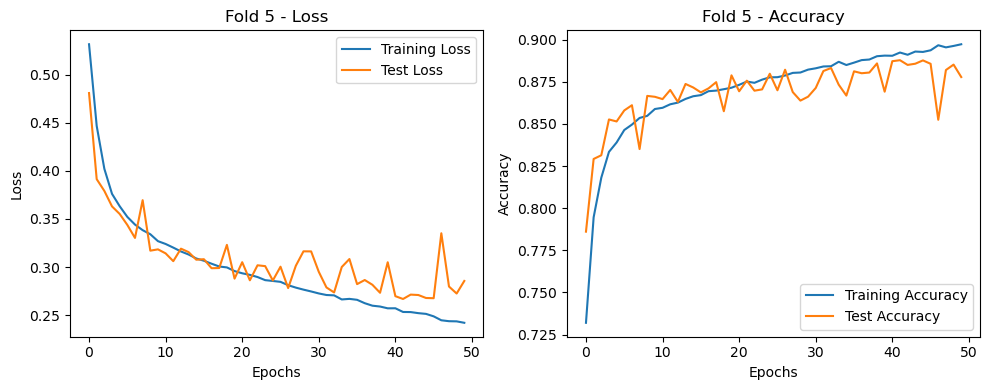

Le score moyen est de : 0.8843452453613281


In [13]:

from sklearn.metrics import classification_report



# Définir le nombre de folds pour la validation croisée
k = 5

# Créer un objet StratifiedKFold
kf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

# Liste pour stocker les scores de validation pour chaque fold
val_scores = []

# Liste pour stocker les rapports de classification pour chaque fold
classification_reports = []


# Boucle sur les folds
for fold, (train_index, test_index) in enumerate(kf.split(X_train, y_train), 1):
    # Séparer les données en ensembles d'entraînement et de validation pour ce fold
    X_train_fold, X_val_fold = X_train[train_index], X_train[test_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[test_index]

    # Créer, compiler et entraîner votre modèle
    model = modele_CNN() 
       
   
    # Entraîner le modèle avec validation croisée
    history = model.fit(X_train_fold, y_train_fold, epochs=50, batch_size=32, validation_data=(X_val_fold, y_val_fold))

    # Prédire les probabilités des classes sur l'ensemble de validation
    y_pred_probs = model.predict(X_val_fold)

    # Arrondir les probabilités pour obtenir les classes binaires (0 ou 1)
    y_pred = np.round(y_pred_probs)

    # Convertir les classes prédites en entiers (0 ou 1)
    y_pred = y_pred.astype(int)
 # Calculer et afficher le rapport de classification
    report = classification_report(y_val_fold, y_pred, target_names=['0', '1'], output_dict=True)
    report_ind = classification_report(y_val_fold, y_pred)
    print("Fold {}: \n{}".format(fold, report_ind))


     # Ajouter le rapport de classification à la liste
    classification_reports.append(report)

    # Évaluer le modèle sur l'ensemble de validation et enregistrer le score
    _, val_score = model.evaluate(X_val_fold, y_val_fold)
    val_scores.append(val_score)

    # Afficher les courbes de perte et de précision pour l'entraînement et la validation
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Test Loss')
    plt.title('Fold {} - Loss'.format(fold))
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Test Accuracy')
    plt.title('Fold {} - Accuracy'.format(fold))
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()
    
# Calculer la moyenne des scores de validation
mean_val_score = np.mean(val_scores)
print("Le score moyen est de :", mean_val_score)


Au regard de ce qui précède, pour chaque fold données la courbe de la fonction de perte décroit et l'accuracy augmente. La précision moyenne est de 88,43%. Notre modèle fonctionne donc bien et est donc capable de discriminer à 88,43% les classes. 
Nous allons faire sortir un raport détaillé de la classification pour mieux apprécié notre modèle. Nous allons calculé les métriques moyennes par classe pour ce faire.

# Evaluation du modèle

In [14]:
# Calculer la moyenne des métriques de classification pour les classes 0 et 1
average_classification_report = {0: {}, 1: {}}

# Pour chaque classe
for class_label in [0, 1]:
    # Initialiser les totaux des métriques pour cette classe
    total_precision = 0
    total_recall = 0
    total_f1_score = 0
    total_support = 0

# Pour chaque rapport de classification dans la liste
    for report in classification_reports:
        # Ajouter les métriques de cette classe au total
        total_precision += report[str(class_label)]['precision']
        total_recall += report[str(class_label)]['recall']
        total_f1_score += report[str(class_label)]['f1-score']
        total_support += report[str(class_label)]['support']

    # Calculer la moyenne des métriques pour cette classe
    average_precision = total_precision / len(classification_reports)
    average_recall = total_recall / len(classification_reports)
    average_f1_score = total_f1_score / len(classification_reports)

    # Ajouter les moyennes au rapport de classification moyen
    average_classification_report[class_label]['precision'] = average_precision
    average_classification_report[class_label]['recall'] = average_recall
    average_classification_report[class_label]['f1-score'] = average_f1_score
    average_classification_report[class_label]['support'] = total_support



from tabulate import tabulate

# Convertir le rapport de classification moyen en format de tableau
table = [["Classe", "Précision_moy", "Recall_moy", "F1-score_moy", "Support"]]
for class_label in average_classification_report.keys():
    precision = average_classification_report[class_label]['precision']
    recall = average_classification_report[class_label]['recall']
    f1_score = average_classification_report[class_label]['f1-score']
    support = int(average_classification_report[class_label]['support'])
    table.append([class_label, precision, recall, f1_score, support])

# Afficher le tableau
print(tabulate(table, headers="firstrow", floatfmt=".3f"))

  Classe    Précision_moy    Recall_moy    F1-score_moy    Support
--------  ---------------  ------------  --------------  ---------
       0            0.897         0.868           0.882      41840
       1            0.874         0.900           0.887      42160


En moyenne la métrique Recall=0.90. Cela indique qu'en moyenne notre modèle est capablde de détecter à 90% sur les cas positifs réel le risque pour un patient donné d'avoir le cancer de sein. 